In [22]:
from read_data import read_enhanced_microscore_dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from plots import first_plot, second_plot, third_plot, forth_plot, plot_performance, fith_plot
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

In [23]:
df = read_enhanced_microscore_dataset()

In [24]:
df["PrecioM2"] = df["Precio"]/df["Metros"]

In [25]:
df_base = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "PrecioM2",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    'Caracteristicas'
]]

In [26]:
df_microscore = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "PrecioM2",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    "RentaBrutaHogar",
    "RentaBrutaPersona",
    "poblacion_2023",
    "%_servicios",
    "densidad_inm_m2",
    "%_agricultura",
    "%_industria",
    "%_construccion",
    'Caracteristicas',
    'University_Distance',
    'School_Distance', 'Kindergarten_Distance', 'City Center_Distance',
       'Supermarket_Distance', 'Bakery_Distance', 'Hospital_Distance',
       'Pharmacy_Distance', 'Restaurant_Distance', 'Café_Distance',
       'Park_Distance', 'Gym_Distance', 'Movie Theater_Distance',
       'Theater_Distance', 'Shopping Mall_Distance', 'Bus Stop_Distance',
       'Metro Station_Distance', 'Score'
]]

In [27]:
def prepare_data(df):
    categorical_cols = ['Caracteristicas']
    df = pd.get_dummies(df, columns=categorical_cols)
    df = df.fillna(-1)
    return df

In [28]:
df_base =prepare_data(df_base)
df_microscore =prepare_data(df_microscore)

In [29]:
df_base.shape

(68228, 13)

In [30]:
df_microscore.shape

(68228, 39)

In [31]:
def knn_grid_search(df):
    X = df.drop(columns=["PrecioM2", "Precio"])  
    y = df["PrecioM2"]  # Objetivo PrecioM2

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
    
    # Grid search
    param_grid = {
        'n_neighbors': [1, 2, 5, 10],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1]  
    }
    
    knn = KNeighborsRegressor()
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # Iniciar GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        cv=2,  
        scoring=scorer,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  
    
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation MSE: {best_score}")

In [11]:
knn_grid_search(df_base)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'p': 1}
Best Cross-Validation MSE: 1202290.6581214997


In [12]:
knn_grid_search(df_microscore)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'p': 1}
Best Cross-Validation MSE: 699418.3342006531


In [32]:
def knn_kfold(df, n_neighbors, distance):
    X = df.drop(columns=["PrecioM2", "Precio"])
    y = df["PrecioM2"]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=56)
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric=distance)
    
    mae_list = []
    rmse_list = []
    mape_list = []
    
    # 5 kfold validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        metros_test = df.iloc[test_index]["Metros"]
        precio_test = df.iloc[test_index]["Precio"]

        # Escalado
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entrenamiento
        knn.fit(X_train_scaled, y_train)
        
        # Prediccion
        y_pred_precio_m2 = knn.predict(X_test_scaled)
        
        # Prediccion Precio como PrecioM2 * Metros
        y_pred_precio = y_pred_precio_m2 * metros_test

        # Comparacion
        comparison_df = pd.DataFrame({
            'Actual Precio': precio_test,
            'Predicted Precio': y_pred_precio
        })
        
        mae = mean_absolute_error(precio_test, y_pred_precio)
        rmse = np.sqrt(mean_squared_error(precio_test, y_pred_precio))
        mape = mean_absolute_percentage_error(precio_test, y_pred_precio)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)
        
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    
    # Display average metrics across all folds
    print("\n--- Metricas Cross-Validation ---")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average RMSE: {np.mean(rmse_list):.2f}")
    print(f"Average MAPE: {np.mean(mape_list):.2%}")

    return precio_test, y_pred_precio

In [33]:
y_test_base, y_pred_base = knn_kfold(df_base, 10, "manhattan")

MAE: 72336.78, RMSE: 169382.57, MAPE: 32.79%
MAE: 70473.38, RMSE: 162583.60, MAPE: 31.92%
MAE: 74090.78, RMSE: 186497.11, MAPE: 32.72%
MAE: 71536.71, RMSE: 168103.23, MAPE: 31.69%
MAE: 73587.31, RMSE: 167764.04, MAPE: 32.99%

--- Cross-Validation Metrics ---
Average MAE: 72404.99
Average RMSE: 170866.11
Average MAPE: 32.42%


In [34]:
y_test_micro, y_pred_micro = knn_kfold(df_microscore, 10, "manhattan")

MAE: 60868.69, RMSE: 136688.08, MAPE: 27.69%
MAE: 61565.26, RMSE: 142087.14, MAPE: 27.58%
MAE: 62793.10, RMSE: 166458.13, MAPE: 27.70%
MAE: 63637.38, RMSE: 183476.50, MAPE: 27.72%
MAE: 63496.63, RMSE: 178868.46, MAPE: 27.82%

--- Cross-Validation Metrics ---
Average MAE: 62472.21
Average RMSE: 161515.66
Average MAPE: 27.70%


C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_blue = df_plot_base.groupby("log_bin")["%error"].mean().reset_index()
C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_red = df_plot__micro.groupby("log_bin")["%error"].mean().reset_index()


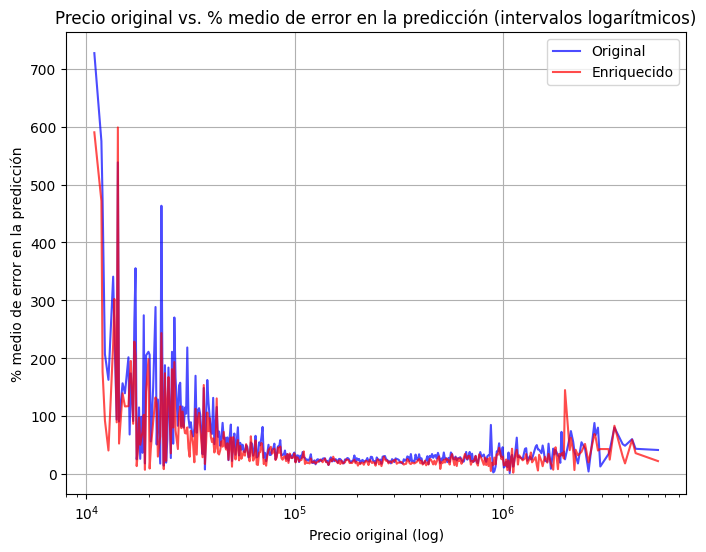

In [21]:
fith_plot(y_test_base, y_pred_base, y_test_micro, y_pred_micro)